In [6]:
!pip3 install numpy==1.19.3

  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Acceso denegado: 'C:\\Users\\cande\\anaconda3\\Lib\\site-packages\\~umpy\\.libs\\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [7]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [12]:
img_height, img_width = (64,64)
batch_size = 32
train_data_dir = r"Faces_by_house_processed/train"
valid_data_dir = r"Faces_by_house_processed/val"
test_data_dir = r"Faces_by_house_processed/test"

In [13]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2, zoom_range=0.2,validation_split=0.4)
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size = (img_height,img_width),
                                                   batch_size=batch_size, class_mode="categorical", 
                                                    subset="training")
valid_generator = train_datagen.flow_from_directory(valid_data_dir, target_size = (img_height,img_width),
                                                   batch_size=batch_size, class_mode="categorical", 
                                                    subset="validation")


Found 189 images belonging to 4 classes.
Found 13 images belonging to 4 classes.


In [14]:
test_generator = train_datagen.flow_from_directory(test_data_dir, target_size = (img_height,img_width),
                                                   batch_size=1, class_mode="categorical", 
                                                    subset="validation")

Found 15 images belonging to 4 classes.


In [15]:
x,y = test_generator.next()
x.shape

(1, 64, 64, 3)

In [16]:
base_model = ResNet50(include_top=False,weights="imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(train_generator.num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable=False
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics = ["accuracy"])
model.fit(train_generator, epochs=10)

94773248/94765736 [==============================] - 7s 0us/step
Epoch 1/10
6/6 [==============================] - 5s 275ms/step - loss: 9.5888 - accuracy: 0.2936
Epoch 2/10
6/6 [==============================] - 1s 186ms/step - loss: 4.4531 - accuracy: 0.3414
Epoch 3/10
6/6 [==============================] - 1s 188ms/step - loss: 3.7800 - accuracy: 0.4390
Epoch 4/10
6/6 [==============================] - 1s 197ms/step - loss: 1.5590 - accuracy: 0.4283
Epoch 5/10
6/6 [==============================] - 1s 197ms/step - loss: 1.0490 - accuracy: 0.5494
Epoch 6/10
6/6 [==============================] - 1s 194ms/step - loss: 0.9420 - accuracy: 0.6375
Epoch 7/10
6/6 [==============================] - 1s 188ms/step - loss: 0.8302 - accuracy: 0.7085
Epoch 8/10
6/6 [==============================] - 1s 191ms/step - loss: 0.7945 - accuracy: 0.6780
Epoch 9/10
6/6 [==============================] - 1s 193ms/step - loss: 0.8063 - accuracy: 0.6775
Epoch 10/10
6/6 [==============================] - 1s

In [17]:
model.save("Model/ResNet50_faces.h5")

In [18]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

15/15 - 1s - loss: 1.5174 - accuracy: 0.3333

Test accuracy: 0.3333333432674408


In [19]:
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [20]:
model=tf.keras.models.load_model("Model/ResNet50_faces.h5")
filenames = test_generator.filenames
nb_samples=len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test=test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]


Test accuracy:40.0


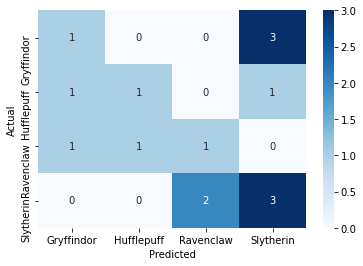

In [21]:
out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,
                      columns=["predicted_class","actual_class"])
confusion_matrix=pd.crosstab(out_df["actual_class"], out_df["predicted_class"], 
                             rownames=["Actual"], colnames=["Predicted"])
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, fmt="d")
plt.show
print("Test accuracy:{}".format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))